# INFO-H-515 -  Big Data : Distributed Data Management and Scalable Analytics

### Geisser Niklaus -  [niklaus.geisser@ulb.be](mailto:niklaus.geisser@ulb.be) - Student ID 469478
### Gerard Joan -       [joan.sebastian.gerard.salinas@ulb.be](mailto:joan.sebastian.gerard.salinas@ulb.be) - Student ID 471612

# Time Series Prediction with Linear Models


# Introduction

The main goal of this project was to apply the knowledge acquired during the course by designing and implementing an online forecasting system. In order to achieve this purpose, Kafka was used as the distributed streaming platform whereas spark handled all the corresponding data processing to make predictions in a distributed way.

## General imports

In [1]:
import time
import re, ast
import numpy as np
import os
import glob
import json
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn import linear_model
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from message import Message
from rls import RLS

### Start Spark session


A spark session is defined with a certain number of executors.

In [2]:
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils


os.environ['PYSPARK_SUBMIT_ARGS'] = '--conf spark.ui.port=4040 '+\
                        '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.4 '+\
        '--conf spark.driver.memory=2g  pyspark-shell'

executors = 2

spark = SparkSession \
    .builder \
    .master("local[{0}]".format(executors)) \
    .appName("KafkaReceive") \
    .getOrCreate()

### General methods

Function to connect Spark Streaming and Kafka on a given topic

In [3]:
#This function creates a connection to a Kafka stream
#You may change the topic, or batch interval
#The Zookeeper server is assumed to be running at 127.0.0.1:2181
#The function returns the Spark context, Spark streaming context, and DStream object
def getKafkaDStream(spark,topic='persistence',batch_interval=10):

    #Get Spark context
    sc=spark.sparkContext

    #Create streaming context, with required batch interval
    ssc = StreamingContext(sc, batch_interval)

    #Checkpointing needed for stateful transforms
    ssc.checkpoint("checkpoint")
    
    #Create a DStream that represents streaming data from Kafka, for the required topic 
    dstream = KafkaUtils.createStream(ssc, "127.0.0.1:2181", "spark-streaming-consumer", {topic: 1})
    
    return [sc,ssc,dstream]


The following method transforms the received stream into a an object of type Message (class defined in message.py file) which has the id of the stream and the corresponding data-points.

In [4]:
def parse_message(x):
    """
    This message transforms the received json string into a message object.
    
    :param x string containing the message
    
    :return Message
    """
    messageDict = x[1]
    messageDict = json.loads(messageDict)
    message = Message()
    message.id = messageDict["id"]
    message.x = messageDict["x"]
    return message
    

The following method retreives the MSE, data-points, predictions and id of the last saved data stream. In this particular case, the retreived file will have the mentioned data for a specific time interval (e.g (500,1000]))

In [5]:
def get_data_from_file(executors, prefix='test', search_dir = "./", file_index=-1):
    """
    In charge of reading the last file containing information regarding the last stream
    and processing it to return an tuple with the keys, mses and the stream data.
    
    :param executors If the algorithm uses 2 executors then this will create two partitions [0,1] if it is 4 it will be [0,1,2,3]
    :param prefix     It is the prefix of the directory name
    :param search_dir Where it should the algorithm look for these files
    :param file_index If it is -1 it will use the last file (containing the last stream data), if it is 0 it will
                      use the first file (containing the first stream data)
                      
    :return (keys_all, mses_all, ys_all)     keys, mses, data points, 
    """
    keys_all = []
    mses_all = []
    ys_all = []
    y_hat_all = []
    idx = -1
    
    count = 0
    
    files = list(filter(os.path.isdir, glob.glob(search_dir + prefix +"*")))
    files.sort(key=lambda x: os.path.getmtime(x))

    for j in range(executors):
        file_name = "/part-0000%s" % str(j)
        data=files[file_index] + file_name
        F=open(data, "r")
        models = F.read().split('\n')

        for model in models:
            if (len(model) > 0):
                count += 1
                rls1 = model.split(' separator ')
                key = rls1[0]
                mses = list(map(lambda x: float(x), rls1[1][1:-1].split(',')))
                ys = list(map(lambda x: float(x), rls1[2][1:-1].split(',')))
                y_hat = list(map(lambda x: float(x), rls1[3][1:-1].split(',')))
                idx = int(rls1[4])
                keys_all.append(key)
                mses_all.append(mses)
                ys_all = ys
                y_hat_all.append(y_hat)
                
    return (keys_all, mses_all, ys_all, y_hat_all, idx)

The following methods are used to plot the mse, data-points and predictions of a model in order to have a visual representation of the performance of the implemented models.

In [6]:
def plot_mse(range_view_start, range_view_end, keys, mses):
    """
    It plots the mse for a given range. If the stream size is 1000 then the max value for range_view_end is 1000.
    
    :param range_view_start Start of the range
    :param range_view_end   End of the range
    :param keys             The name of the models
    :param mses             The mses values
    
    """
#     fig = plt.figure(figsize=(16,6))
    x = np.arange(range_view_start, range_view_end)
    for i in range(len(keys)):
        plt.plot(x, mses[i], label=keys[i])
#         print(len(mses[i]))

    plt.title('MSE')
    plt.legend(loc="upper left")
    plt.xlabel('time')
    plt.ylabel('mse')
    plt.show()

In [7]:
def plot_time_series(range_view_start, range_view_end, ys, linewidth = 0.9):
    """
    It plots the time series for a given range. If the stream size is 1000 then the max value for range_view_end is 1000.
    
    :param range_view_start Start of the range
    :param range_view_end   End of the range
    :param keys             The name of the models
    :param mses             The mses values
    
    """
    fig = plt.figure(figsize=(16,6))
    x = np.arange(range_view_start, range_view_end)
    plt.plot(x, ys,linewidth=linewidth)
#     plt.ylim(0,2)
    plt.title('Time Series')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.show()

In [8]:
# 700, 720, 500
def plot_time_series_prediction(zoom_scale_start, zoom_scale_end, keys, ys, y_hat, original_range_start,linewidth = 0.9):
    """
    It plots the time series for a given range. If the stream size is 1000 then the max value for zoom_scale_end is 1000.
    
    :param zoom_scale_start Start of the range
    :param zoom_scale_end   End of the range
    :param keys             The name of the models
    :param mses             The mses values
    :param ys               time series values
    :y_hat                  predictions
    
    """
    
    # Adding subplots dynamically based on the number of models

    tot = len(keys)
    cols = 2
    
    rows = tot // cols 
    rows += tot % cols
    position = range(1,tot + 1)
    
    plt.subplots_adjust(wspace = 0.8, hspace = 0.8)
    fig = plt.figure(1)
    fig.suptitle('Time Series vs Prediction', fontsize=15)

    for k in range(tot):
#         print(len(y_hat[k]))
        # add every single subplot to the figure with a for loop
        fig.set_figheight(6) 
        fig.set_figwidth(16)
        
        ax = fig.add_subplot(rows,cols,position[k])
        x = np.arange(zoom_scale_start, zoom_scale_end)
        ax.plot(x, ys[zoom_scale_start - original_range_start: zoom_scale_end - original_range_start], label="Time series", linewidth=linewidth)
        ax.plot(x, y_hat[k][zoom_scale_start - original_range_start: zoom_scale_end - original_range_start], label="Prediction",linewidth=linewidth)
        
        ax.legend(loc="upper right")
        ax.set_title(keys[k])
        ax.set_xlabel("time")
        ax.set_ylabel("values")
          
    

In [75]:
def plot_mse_comparison(mses, keys, title="", y_label="mse", x_label='', rotation=0):
    """
    Bar plot to compare MSEs
    :param mses: 
    :param keys: 
    :param title: 
    :param y_label: 
    :param x_label: 
    :param rotation: 
    """
    plt.bar(keys, mses, align='center', alpha=0.5)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.show()

# Persistence model

In this section, a basic persistence model will be implemented where the prediction of a future timestep will depend on the average values of previous timesteps. A "naive" approach will be to make a prediction based on the previous timestep which will be equivalent to the "average" of the last value. In order to have a more detail comparsion, several approaches will be tested for doing the average of the last "V" values  (weighted persistence model). The main purpose of implementing this model is to have a base point of reference regarding the performance of other models. 

The following method is in charge of computing the prediction of a future time-step based on of the last "V" values (tail). The idea is to concatenate the tail to the current stream and use a sliding window of size "V" to make the prediction.

In [79]:
def persistence_prediction(stream, tail):
    """
    Computes the prediction of future time-steps based on a stream and last "V" values.
    
    :param stream  list of elements received by kafka
    :param tail    last "V" values of a previous stream
    
    :return:       predictions
    """
    predictions = []
    len_tail = len(tail)  # Length of V
    last_values_plus_stream = np.concatenate((tail, np.array(stream))) # Array that contains the "V" last elements of the stream
    
    for time_in_stream in range(len(stream)):
        time_in_concat = time_in_stream + len_tail
        sliding_window = last_values_plus_stream[time_in_stream:time_in_concat]
        prediction = np.mean(sliding_window)
        predictions.append(prediction)
        
    return predictions

The following method is in charge of updating the state of the model, the MSE is accumulated along with the data-points and the prediction for a given interval of time (e.g (500,1000]). The same update function can be used for the simple persistence model (V = 1) and the average persistance models V = {2 ,3 ,4}.

In [80]:
def update_function_persistence(new_values, state):
    """
    Updates the state for the persistence models.
    
    :param new_value  stream to be processed
    :param state      current state in memory
    
    :return:          new state
    """
    L = len(new_values)
    
    if L > 0:
        key, predictions, tail, mse, mses, D, N, idx, init_interval, end_interval = state  # Unpacking the state

        for message in new_values:
            stream = message.x
            idx = message.id
            
            result_predictions = persistence_prediction(stream, tail)
            if N == 0:  # Replace the "v" first values of the predictions with the "v" first values of the stream if first time
                result_predictions[:len(tail)] = stream[:len(tail)]
            tail = stream[-len(tail):]  # Update last V values of stream
            err = np.subtract(stream, result_predictions)  ## prediction error for the latest values
            
            for idx, e in enumerate(err):
                N += 1
                mse = mse + 1.0 / N * (pow(e, 2.0) - mse)  ## sequential update of MSE
                if (N >= init_interval + 1 and N <= end_interval): # Check if the message is within the interval to be study
                    mses.append(mse.tolist())
                    D.append(stream[idx])
                    predictions.append(result_predictions[idx])
            
        return key, predictions, tail, mse, mses, D, N, idx, init_interval, end_interval
    else:
        return state

The following method is in charge of initializing the inital state for all the models.

In [81]:
def get_initial_state_persistence(v, sc, init_interval=500, end_interval=1000):
    """
    Gets the initial state for persistence models.
        ex: v = [1,2,3, 4]
            return RDD with values [('V1', state_V1),('V2', state_V2),('V3', state_V3),('V4', state_V4)]
    
    :param v:  Numbers array of last values required to average
    
    :return:   [(key, state)] RDDS
    """
    rdds = []
    for value in v:
        key = 'V%s' % str(value)
        tail = np.zeros(value)  # V last elements from previous stream (initially set to 0)
        mse = 0  # mean square error
        mses = [] # history of mse
        D = [] # processed stream
        predictions = []  # Empty array that will store the predicted values for the received stream (Just for visual purposes)
        N = 0  #
        state = (key, predictions, tail, mse, mses, D, N, 0, init_interval, end_interval)
        rdd = (key, state)
        rdds.append(rdd)
    return sc.parallelize(rdds)


Here the interval of time for which the MSE, data-points and predictions will be accumulated is defined. 

In [82]:
init_interval = 500
end_interval = 1000

As mentioned above, all the required models will be computed in parallel, once the state is updated, the MSE, data-points, predictions and id of the model will be saved into a text file to be used later.

In [83]:
V = [1,2,3,4] # Averaging the last 1, 2, 3 and 4 values of stream. 

[sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='timeSerieS',batch_interval=1)
initial_state_RDD_persistance = get_initial_state_persistence(V, sc, init_interval, end_interval)
data_stream = dstream.map(parse_message)

data_stream = data_stream.flatMap(lambda message: [('V%s' % str(v), message) for v in V])
updated_stream=data_stream.updateStateByKey(update_function_persistence,initialRDD=initial_state_RDD_persistance)
# key separator mses separator stream separator predictions separator id
output_stream = updated_stream.map(lambda x: "%s separator %s separator %s separator %s separator %s" % (str(x[1][0]), str(x[1][4]), str(x[1][5]),str(x[1][1]), str(x[1][7]))).saveAsTextFiles('test-persistence')


In [84]:
ssc.start()

In [85]:
ssc.stop(stopSparkContext=False,stopGraceFully=False)

## Visualize MSE and Time Series

In this section, different plots will be showed to see the performance of the implemented models

The first step is to retreive the last stream saved that will contain the accumulated data for the interval defined above. (e.g (500 , 1000])

In [86]:
(keys, mses_persistence, ys, y_hat_persistence, idx) = get_data_from_file(executors, prefix='test-persistence')

The MSE of the last prediction for each model can be retreived to evaluate the models performance.

In [87]:
for idx,mse in enumerate(mses_persistence):
    print("{0} : {1}".format(keys[idx],mse[-1]))

V1 : 5.65360450789489
V2 : 4.247589350479938
V3 : 3.761347242500189
V4 : 3.540525294862486


It can be seen that the model that averages the last four values has a smaller MSE error. This assumption can be confirmed by visualizing the MSE along with the predictions in every time-step of the interval to be studied (e.g (500, 1000]).

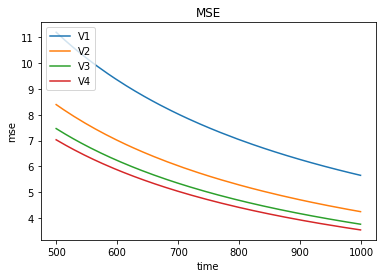

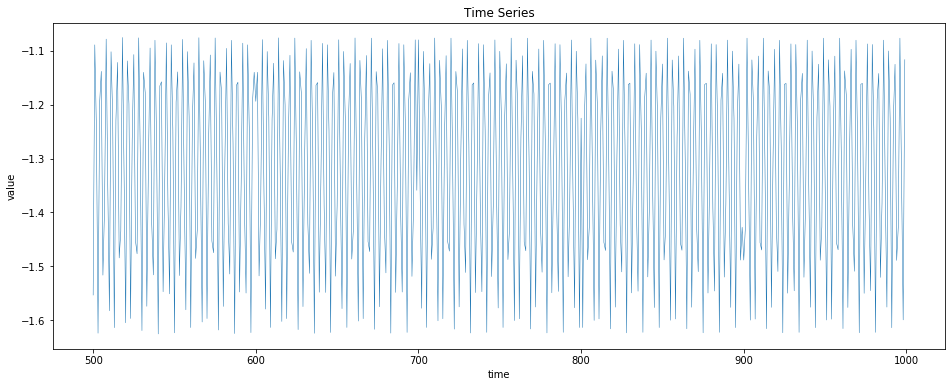

In [89]:
plot_mse(init_interval, end_interval, keys, mses_persistence)
plot_time_series(init_interval, end_interval, ys, 0.5)

It can be seen from the results obtained that averaging the last 4 values gives a lower mean-square-error, this makes sense since there is much more information about past time-steps. 

## Visualize Time Series with predictions

The following plots show the prediction for each data-point of the different models implemented.

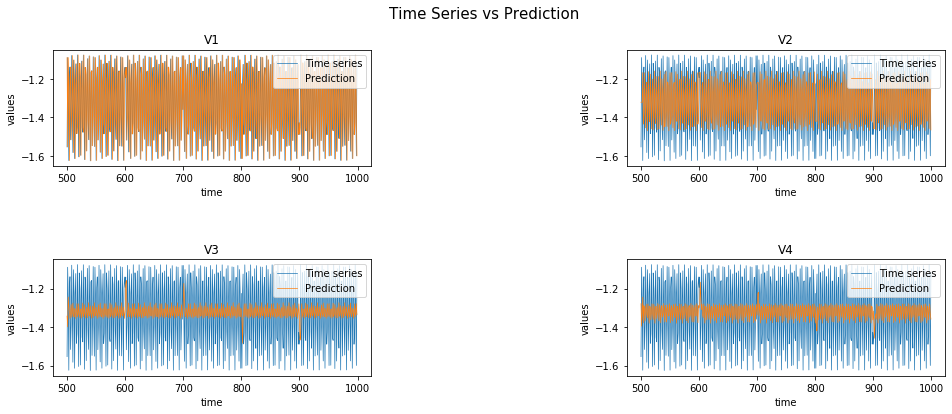

In [90]:
plot_time_series_prediction(init_interval, end_interval, keys, ys, y_hat_persistence, init_interval,0.7)

One cannot appreciate very much the predictions on the data-points given the length of the time interval. For instance, it would seem that the simple persitance model (V = 1) has a better accuracy regarding the prediction. If the interval is reduced, then it is easier to see the predictions in a smaller scale.

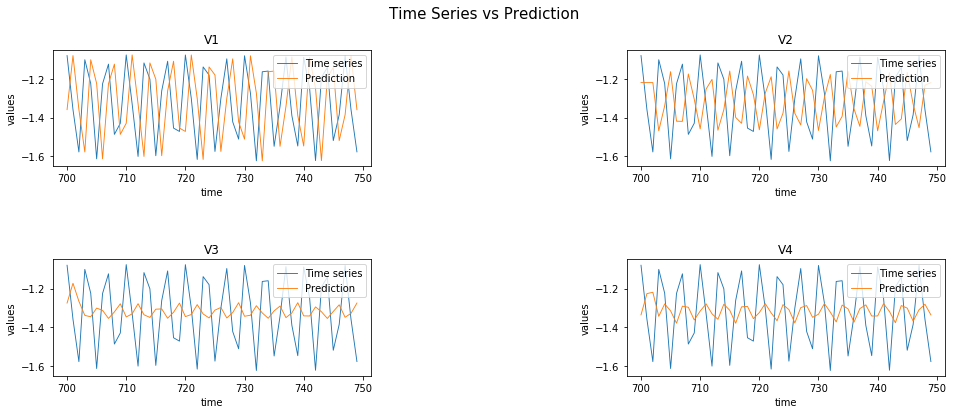

In [91]:
plot_time_series_prediction(700,750, keys, ys, y_hat_persistence, init_interval)

# Parallel linear models

In this section, the predictions will be made by implementing the Recursive Least Squares (RLS) strategy studied during the course with different number of parameters (n = {1,2,3,4}). These linear models will be implemented in parallel by using paired RDDs.

In order to make the predictions it is necessary to build a dataset on the data-points based on the number of parameters, the following method is in charge of building such data set. For instance, if <b>n</b> = 2 and <b>x</b>  = [1,2,3,4,5], then the resulting data set will be:

| x0 	| x1 	| x2 	| y 	|
|----	|----	|----	|---	|
| 1  	| 1  	| 2  	| 3 	|
| 1  	| 2  	| 3  	| 4 	|
| 1  	| 3  	| 4  	| 5 	|

In [93]:
def build_data_set(message, n):
    """
    For message.x = [3,4,5,6,7] and n = 2 this function constructs:
    
    xy = [
        [1, 3, 4, 5], # x1=1, x2=3, x3=4, y=5
        [1, 4, 5, 6], # x1=1, x2=4, x3=5, y=6
        [1, 5, 6, 7], # x1=1, x2=5, x3=6, y=7
    ]
    
    :param message Object Message containing data stream
    :param n       Int containing the number of features 
    
    :return (id, XY_dataset)
    """
    
    ones = [1] * (len(message.x) - n)
    xy = [ones]
    size = len(message.x)
    
    for i in range(n+1):
        xy.append(message.x[i: size + i - n])
    
    xy = np.transpose(xy)
    return (message.id, xy)

The following method processes one learning step of the Recursive Least Squares Algorithm returning the updated values of $\beta$ parameters, covariance matrix $V$ along with the error and the prediction.

In [94]:
def rls_step(y, x, beta, V, nu):
    """
    Recalculates the values for RLS
    
    :param y     Float target value
    :param x     Array of features values
    :param beta  Array of beta values
    :param V     Covariance
    :param nu.   Forgetting Factor
    
    :return (beta, V, err, yhat) updated
    """
    x = np.array(x)
    y = np.array(y)
    V = np.array(V)
    beta = np.array(beta)

    x.shape = (1, len(x))
    beta.shape = (1, x.shape[1])

    V = 1.0/nu * (V - V.dot(x.T).dot(x).dot(V) / (1.0 + float(x.dot(V).dot(x.T))))
    alpha = V.dot(x.T)
    yhat = x.dot(beta.T)
    err = y - yhat
    beta = beta + alpha.T * err

    return (beta, V, err, yhat)

Regarding the state of the linear models, the values of the $\beta$ parameters are accumulated along with the data-points and predictions for the defined interval of time. As it was done in the persistance model, a tail was used to store the "n" last values of a previous stream.

In [95]:
def get_initial_state_linear_models(n, sc, init_interval, end_interval):
    """
    Gets the initial state for persistence models.
        ex: n = [1,2,3, 4]
            return RDD with values [('rls1', state1),('rls2', state2),('rls3', state3),('rls4', state4)]
    
    :param n  Array containing the number of features
    
    :return:  [(key, state)] RDDS
    """
    rdds = []
    for i in n:
        key = 'rls%s' % i
        num_features = i + 1
        beta1=np.zeros(num_features)
        tail = np.zeros(num_features)
        v0=10 ## initialization covariance
        V1=np.diag(np.zeros(num_features)+v0) ## initial covariance matrix for model 1
        nu1=1.0 # forgetting factor for model 1

        recentSize=10
        D=[]
        mses=[]
        predictions= []
        mse=0
        N=0
        state = (key, beta1, V1, nu1, mse, mses, N, D, predictions, tail, i, 0, init_interval, end_interval)
        rdd = (key, state)
        rdds.append(rdd)

    return sc.parallelize(rdds)

The update function works in a similar way as the persistance model with the difference that it accumulates the MSE, data-points and predictions based on the rows of the generated data-set.

In [96]:
def update_function_linear_models(new_values, state):
    """
    Updates the state for the linear models.
    
    :param new_value  stream to be processed
    :param state      current state in memory
    
    :return           new state
    """
    L=len(new_values)

    if (L>0):
        # Extract the data from state variable
        (algo_key, beta, V, nu, mse, mses, N, D, predictions, tail, n, idx, init_interval, end_interval) = state

        # Iterate over all the datasets received
        for i in range(len(new_values)):
            message = new_values[i]
            
            idx = message.id
            
            # add the last n elements from the previous stream to the beginning of the current one
            if (N > 0):
                message.x = tail + message.x
            
            # define new tail for the next stream
            tail = message.x[-n:]
            
            # build data set for current stream
            (key, data_set) = build_data_set(message, n)

            # iterate over all the samples
            for idx, sample in enumerate(data_set):
                y = sample[-1]
                x = sample[:-1]

                # Compute RLS state update
                RL = rls_step(y,x,beta,V,nu)

                # Update the state values
                beta =RL[0]
                V = RL[1]
                err = RL[2]
                N = N + 1
                mse = mse+1.0/N * (pow(err, 2.0) - mse)
                if (N >= init_interval - n +1 and N <= end_interval):
                    mses.append(mse[0][0])
                    D.append(message.x[idx])
                    predictions.append(RL[3][0][0])
            
        return (algo_key, beta, V, nu, mse, mses, N, D, predictions, tail, n, idx, init_interval, end_interval)

    else:
        return state


Five models will be trained in parallel with different orders using the same update function. As it was done before, the MSE, data-points and predictions along with the message id will be stored in several text files depending on the number of executors defined.

In [97]:
n = [1,2,3,4]
init_interval = 500
end_interval = 1000

[sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='timeSerieS',batch_interval=1)
initial_state = get_initial_state_linear_models(n, sc, init_interval, end_interval)

dataS = dstream.flatMap(lambda data: [('rls%s'%i, parse_message(data)) for i in n])
updatedS = dataS.updateStateByKey(update_function_linear_models, initialRDD=initial_state)

# key separator mses separator stream separator predictions
outmseS=updatedS.map(lambda x: "%s separator %s separator %s separator %s separator %s" % (str(x[1][0]), str(x[1][5]), str(x[1][7]), str(x[1][8]), str(x[1][11]))).saveAsTextFiles('test-linear-models')


In [98]:
ssc.start()

In [99]:
ssc.stop(stopSparkContext=False,stopGraceFully=False)

In [100]:
(keys, mses_linear_models, ys, y_hat_linear_models, idx) = get_data_from_file(executors, prefix='test-linear-models')

In [101]:
for idx,mse in enumerate(mses_linear_models):
    print("{0} : {1}".format(keys[idx],mse[-1]))

rls1 : 3.030750883668276
rls2 : 3.8403795661862987
rls3 : 12.688751533231272
rls4 : 13.84125516355414


Once the relevant data is retreived from the saved files, the MSE's, data-points and predictions can be plotted in order to see the performance of the five models.

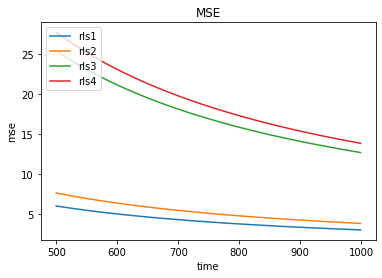

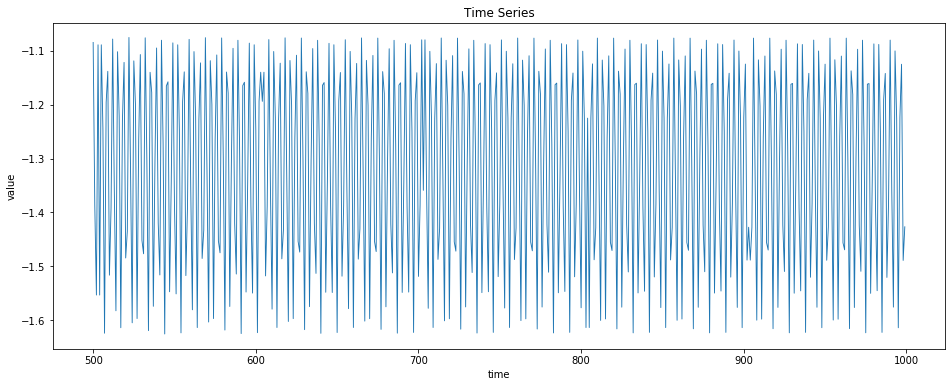

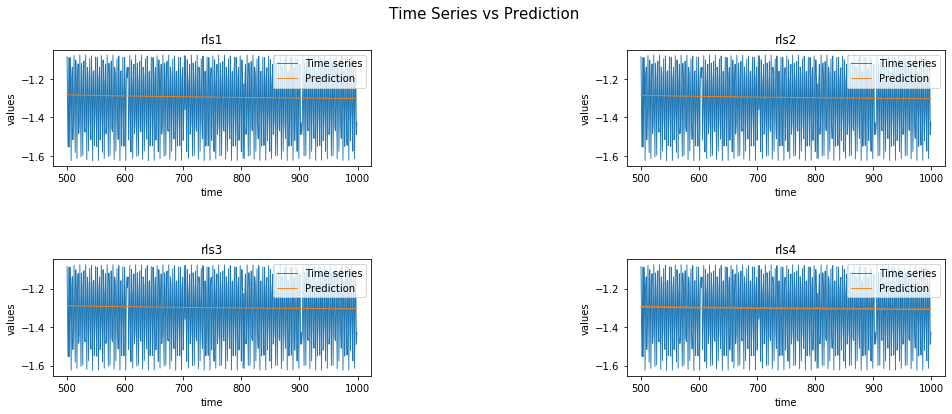

In [102]:
plot_mse(init_interval, end_interval, keys, mses_linear_models)
plot_time_series(init_interval, end_interval, ys)
plot_time_series_prediction(init_interval, end_interval, keys, ys, y_hat_linear_models, init_interval)

It can be seen from the results obtained above that the model which results in a smaller MSE given the interval [500,1000] is "rls1", which is the model with only one parameter. This model outperforms the best persistance model obtained (V4).

|     	| Persistance model V = 4 	| Linear model N = 1 	|
|-----	|-------------------------	|--------------------	|
| mse 	| 3.540                   	| 3.0307             	|

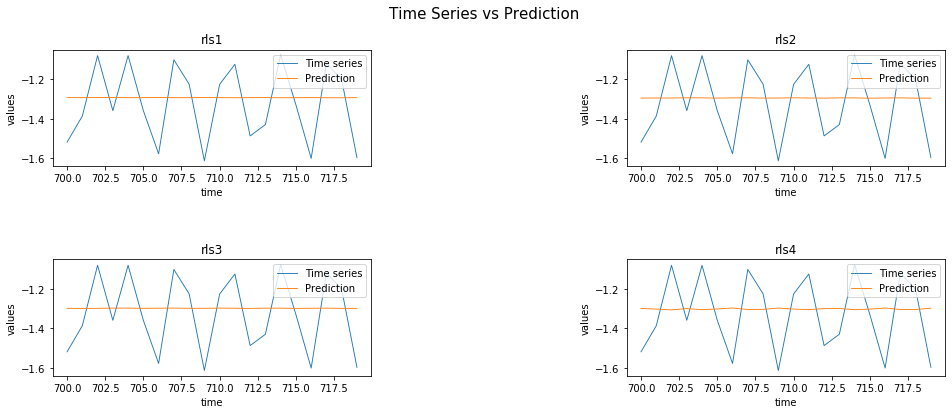

In [103]:
plot_time_series_prediction(700, 720, keys, ys, y_hat_linear_models, init_interval)


## Forgetting factor analysis

As it has been seen in the lectures, there are cases where it is useful not give importance to every element of the data during time, but instead, give more importance to recent data points. An extra parameter called "forgetting factor" represented by $\nu$ was added to the learning step to achieve this purpose.In this section the best model achieved in the previous step will be tested with different forgetting factors ($\nu$ = {0.99, 0.95, 0.9}).

The forgetting factor was added as an extra parameter when building the sate. For this case, the order $n$ is fixed for each model. Note that the same update function used in the previous step can be used.

In [113]:
def get_initial_state_forgettin_factor(nus, num_features, sc, init_interval, end_interval):
    """
    
    """
    rdds = []
    for nu in nus:
        key = 'nu_%s' % str(nu)
        beta1=np.zeros(num_features+1)
        tail = np.zeros(num_features+1)
        v0=10 ## initialization covariance
        V1=np.diag(np.zeros(num_features+1)+v0) ## initial covariance matrix for model 1
        nu1=nu # forgetting factor

        D=[]
        mses=[]
        predictions= []
        mse=0
        N=0
        state = (key, beta1, V1, nu1, mse, mses, N, D, predictions, tail, num_features, 0, init_interval, end_interval)
        rdd = (key, state)
        rdds.append(rdd)

    return sc.parallelize(rdds)

In [114]:
nus = [0.99, 0.95, 0.9]
init_interval = 500
end_interval = 1000

[sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='timeSerieS',batch_interval=1)
initial_state = get_initial_state_forgettin_factor(nus, 1, sc, init_interval, end_interval)

dataS = dstream.flatMap(lambda data: [('nu_%s'%str(nu), parse_message(data)) for nu in nus])
updatedS = dataS.updateStateByKey(update_function_linear_models, initialRDD=initial_state)

# key separator mses separator stream separator predictions
outmseS=updatedS.map(lambda x: "%s separator %s separator %s separator %s separator %s" % (str(x[1][0]), str(x[1][5]), str(x[1][7]), str(x[1][8]), str(x[1][11]))).saveAsTextFiles('test-forgetting-factor')


In [115]:
ssc.start()

In [116]:
ssc.stop(stopSparkContext=False,stopGraceFully=False)

In [120]:
(keys, mses_forgetting_factor, ys, y_hat_forgetting_factor, idx) = get_data_from_file(executors, prefix='test-forgetting-factor')

In [121]:
for idx,mse in enumerate(mses_forgetting_factor):
    print("{0} : {1}".format(keys[idx],mse[-1]))

nu_0.99 : 3.0371024630557617
nu_0.95 : 3.103772594310326
nu_0.9 : 3.235000842643227


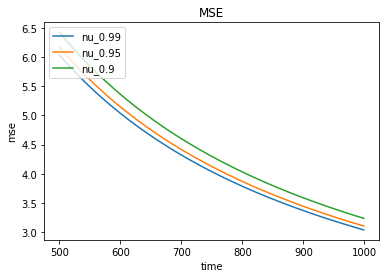

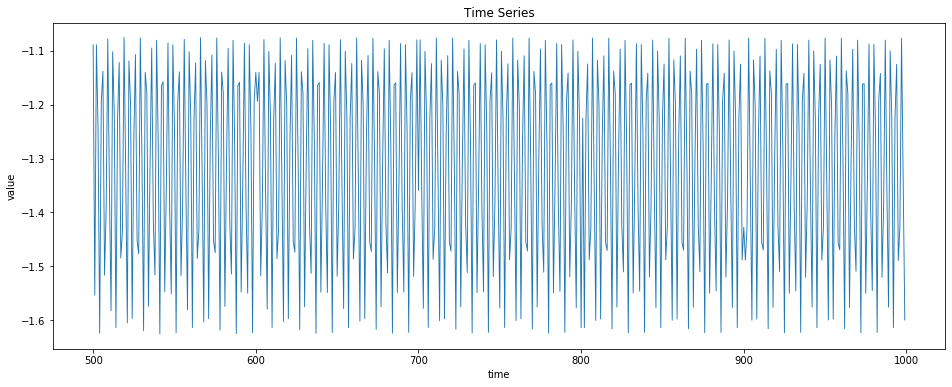

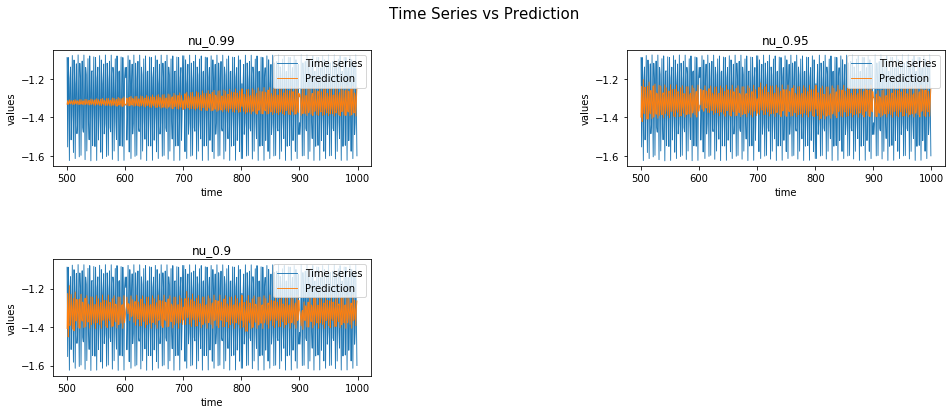

In [122]:
plot_mse(init_interval, end_interval, keys, mses_forgetting_factor)
plot_time_series(init_interval, end_interval, ys)
plot_time_series_prediction(init_interval, end_interval, keys, ys, y_hat_forgetting_factor, init_interval)

It can be seen from the results obtained above that the model which has a forgetting factor of 0.99 has a smaller MSE. This means that past data is relevant to make future predictions as the MSE gets bigger as the forgetting factor decreases in the studied interval ([500,1000])

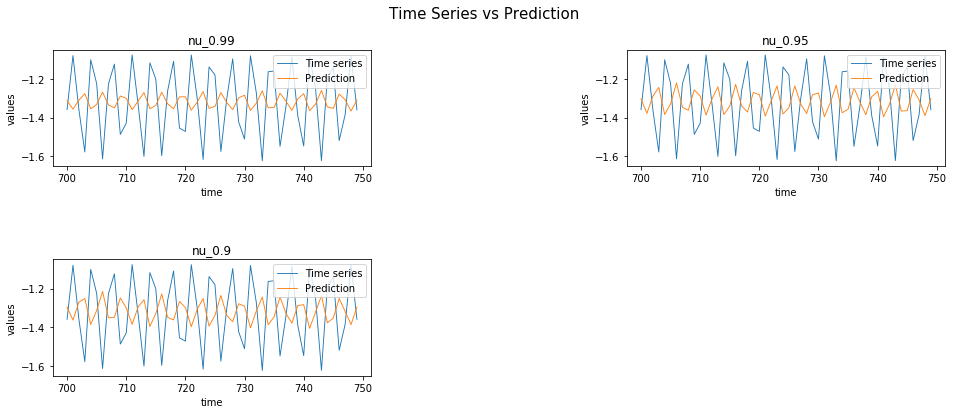

In [123]:
plot_time_series_prediction(700, 750, keys, ys, y_hat_forgetting_factor, init_interval)

It can be seen from the results obtained above that the model which results in a smaller MSE uses a forgetting factor of 0.99. Moreover, the MSE increases proportionally on how much the forgetting factor decreases. This is due to the fact that the past values are relevant in the sense that they reduce the impcat of the noise for fitting the model.

## Bonus : Comparing other strategies

In this section, two different strategies will be compared with the best model obtained from the previous steps. The libraries [creme](https://creme-ml.github.io/index.html#) and [scikit_multiflow](https://scikit-multiflow.github.io/) will be used to make the implementation. These are libraries specifically created for online or in<b>creme</b>ntal learning.

The following models will be implemented:
    

### Hoeffding Tree
This strategy consists on the implementation of an inductive decision tree that can learn from data streams with the assumption that the data distribution does not change. It can be seen by the Hoeffding bound (an upper-bound on the deviation of the expected value for bounded independent random variables), that not many examples are required to choose an optimal splitting attribute.

### KNN regressor
The library [creme](https://creme-ml.github.io/index.html#) provides an online learning approach of the KNN regressor algorithm which uses the nearest neighbors of the training set as a local interpolation. This algorithm could also be used to compare the performance with the persistence model.

### Install creme and scikit multflow

Login as root

- `` yum install gcc-c++ ``

- `` pip install creme ``

- ``pip install -U scikit-multiflow``

In [45]:
from creme import neighbors # K-nearest neighbors

In [46]:
from skmultiflow.trees import RegressionHoeffdingTree, RegressionHAT

The following method is in charge of performing a learning step depending on the model used. It returns the error along with the predictions for a specific regressor.

In [47]:
def step(key, reg, y, x):
    """
    Performs a learning step

    :param key   Key of the algorithm
    :param reg   Regressor
    :param y     Label
    :param x     Features
    

    :return (error, y_hat)
    """
    x = np.array(x)
    y = np.array(y)
    X = dict(zip(range(len(x[1:])), x[1:])) if "creme" in key else x
    y_hat = reg.predict_one(X) if "skmflow" not in key else reg.predict(np.array([X]))
    reg.fit_one(X, y) if "skmflow" not in key else reg.partial_fit(np.array([X]), np.atleast_1d(y))
    err = y - y_hat

    return np.atleast_1d(err), np.atleast_1d(y_hat)

The regressor is added to the state.

In [48]:
def get_initial_state_compare_models(models, num_features, sc, init_interval, end_interval):
    """
    Gets the initial state for comparing models based on a fixed number of parameters
    
    :param models  Array containing the models along with its regressor
    :param n  Array containing the number of features
    :return:  [(key, state)] RDDS
    
    """
    rdds = []
    for idx, model in enumerate(models):
        key = model[0]
        regr = model[1]
        tail = np.zeros(num_features[idx]+1)
        D = []
        mses = []
        predictions = []
        mse = 0
        N = 0
        state = (key, regr, mse, mses, N, D, predictions, tail, num_features[idx], 0, init_interval, end_interval)
        rdd = (key, state)
        rdds.append(rdd)

    return sc.parallelize(rdds)

The update function is similar as previous steps with the difference that all the models use the same learning step. In order to achieve this, a classed RLS has been defined (rls.py file) adding the necessary methods (fit and predict).

In [49]:
def update_function_compare_models(new_values, state):
    """
    Updates the state for the different models.

    :param new_value  stream to be processed
    :param state      current state in memory

    :return           new state
    """
    L = len(new_values)

    if L > 0:
        
        # Extract the data from state variable
        (algo_key, regr, mse, mses, N, D, predictions, tail, n, idx, init_interval, end_interval) = state

        # Iterate over all the datasets received
        for i in range(len(new_values)):
            message = new_values[i]
            
            idx = message.id

            # add the last n elements from the previous stream to the beginning of the current one
            if (N > 0):
                message.x = tail + message.x

            # define new tail for the next stream
            tail = message.x[-n:]

            # build data set for current stream
            (key, data_set) = build_data_set(message, n)

            # iterate over all the samples
            for idx, sample in enumerate(data_set):
                y = sample[-1]
                x = sample[:-1]

                # Compute RLS state update
                e, y_hat = step(algo_key, regr, y, x)

                # Update the state values
                err = e
                N = N + 1
                mse = mse + 1.0 / N * (pow(err, 2.0) - mse)
                if (N >= init_interval - n +1 and N <= end_interval):
                    mses.append(mse[0])
                    D.append(message.x[idx])
                    predictions.append(y_hat[0])

        return (algo_key, regr, mse, mses, N, D, predictions, tail, n, idx, init_interval, end_interval)

    else:
        return state


In [50]:
init_interval = 500
end_interval = 1000

### Initialize models

As mentioned above, the best obtained model will be compared with other machine learning strategies. Each model will be trained using a specific number of features.

- <b>Recursive Least Squares</b> $n = 1$, $nu = 0.99$ (Best model obtained)
- <b>Recursive Least Squares</b> $n = 8$, $nu = 0.99$. Used to evaluate the behaviour with more features
- <b>KNN regressor</b> $n = 8$, n_neighbors=8.
- <b>Regression Hoeffding Tree</b> $n = 8$
- <b>Hoeffding Adapted Tree (HAT)</b> $n = 8$. Tree that uses ADWIN to detect drifts and perceptron to make predictions

In [51]:
num_features = [1, 8, 8, 8, 4]
rls = RLS(num_features[0], 0.99) # Best rls model obtained (n = 1; nu= 0.99)
rls8 = RLS(num_features[1], 0.99) # RLS with 8 parameters (n = 8; nu=0.99)
         
k_neigh = neighbors.KNeighborsRegressor(n_neighbors = 8) # Knn
hoeffding_tree = RegressionHoeffdingTree()
hat_tree = RegressionHAT(leaf_prediction='perceptron') # Adapted Hoeffding Tree using perceptron as leaf predictor

An array of tuples is declared with the key of the algorithm and the respective regressor

In [52]:
models = [("recursive_ls_1", rls), ("recursive_ls_8", rls8), ("creme_knn_regresor", k_neigh), ("skmflow_hoeffding_tree", hoeffding_tree), ("skmflow_hat_tree", hat_tree)]

[sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='timeSerieS',batch_interval=1)
initial_state_racing = get_initial_state_compare_models(models, num_features, sc, init_interval, end_interval)

dataS = dstream.flatMap(lambda data: [(model[0], parse_message(data)) for model in models])
updatedS = dataS.updateStateByKey(update_function_compare_models, initialRDD=initial_state_racing)

# key separator mses separator stream separator predictions
outmseS=updatedS.map(lambda x: "%s separator %s separator %s separator %s separator %s" % (str(x[1][0]), str(x[1][3]), str(x[1][5]), str(x[1][6]), str(x[1][9]))).saveAsTextFiles('test-comparing-models')



In [53]:
ssc.start()

In [54]:
ssc.stop(stopSparkContext=False,stopGraceFully=False)

In [70]:
(keys, mses_compare_models, ys, y_hat_compare_models, idx) = get_data_from_file(executors, prefix='test-comparing-models')

As it can be seen from the results below, all the models have different results regarding the MSE. KNN regressor has a better performance whereas the hoeffding tree algorithm has the biggest MSE. However, the adapted version of the hoeffding tree using the perceptron as leaf predictor has a much smaller error in comparison. Finally, the RLS version with eight parameters has a worse performance in comparison with the best RLS model obtained.

In [71]:
for idx,mse in enumerate(mses_compare_models):
    print("{0} : {1}".format(keys[idx],mse[-1]))

recursive_ls_1 : 3.0371024630557617
creme_knn_regresor : 3.743078527914824
skmflow_hoeffding_tree : 97.49864835333032
skmflow_hat_tree : 16.536475068722403
recursive_ls_8 : 35.072935167464685


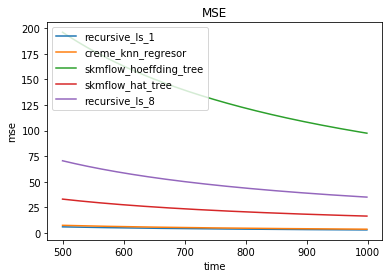

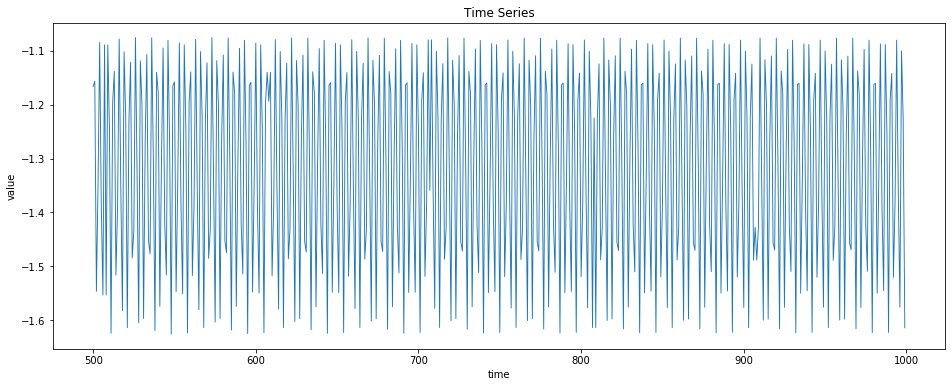

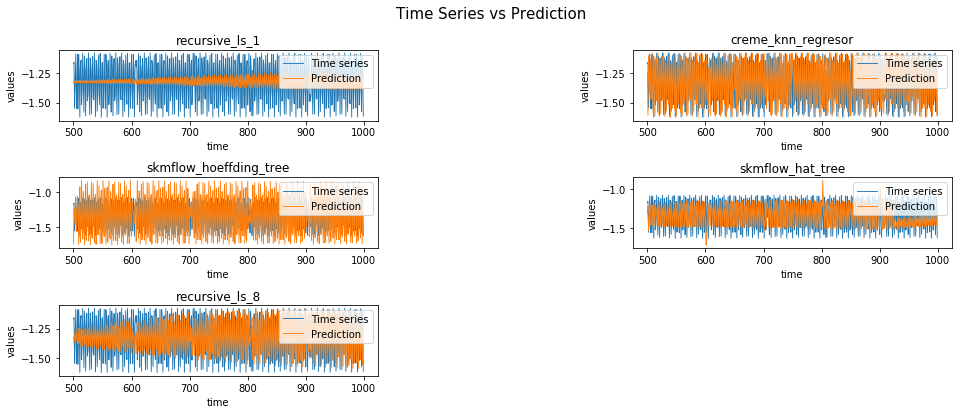

In [72]:
plot_mse(init_interval, end_interval, keys, mses_compare_models)
plot_time_series(init_interval, end_interval, ys)
plot_time_series_prediction(init_interval, end_interval, keys, ys, y_hat_compare_models, init_interval)

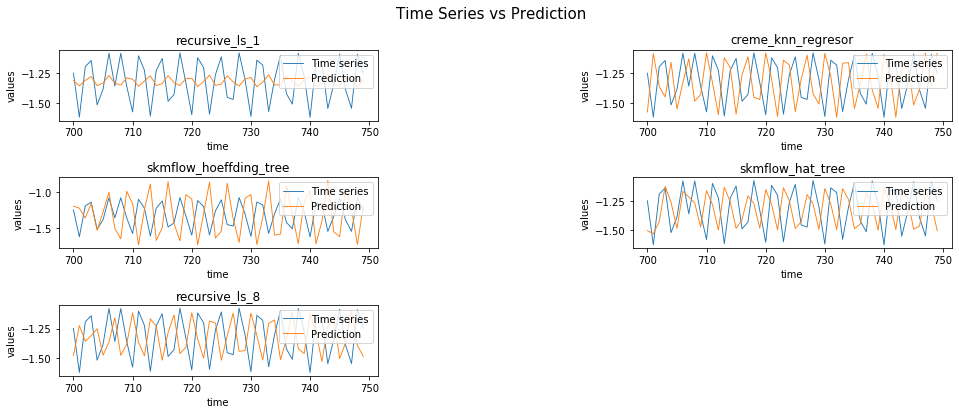

In [73]:
plot_time_series_prediction(700, 750, keys, ys, y_hat_compare_models, init_interval)

From the results obtained above, it can be seen that for the specific interval [500,1000], the model resulting in a smaller MSE is RLS with $n = 1$. However, by looking at the plots displayed above, it can be seen that the other models make the predictions following the shape of the original data-points with some drifts as it is not the case of the best model obtained with RLS.

# Results discussion

After having implemented several models to implement an online forecasting system, a comparison between the best models obtained can be made. The following plots show the MSE of the last time-step as well as the average of all the errors of the studied interval [500,100].

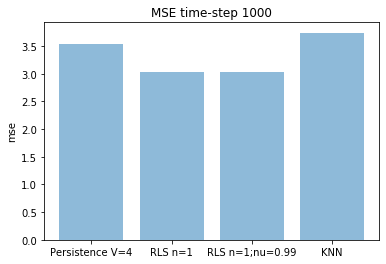

In [126]:
keys = ["Persistence V=4" , "RLS n=1", "RLS n=1;nu=0.99", "KNN"]
last_mse = [mses_persistence[3][-1],
            mses_linear_models[0][-1], 
            mses_forgetting_factor[0][-1], 
            mses_compare_models[1][-1]]

plot_mse_comparison(last_mse,keys, "MSE time-step 1000", "mse", "")

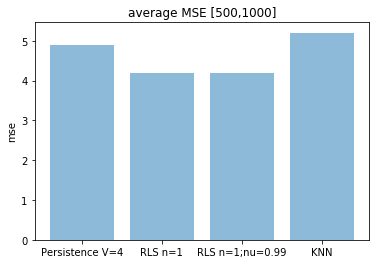

In [128]:
mean_mse = [np.mean(mses_persistence[3]),
            np.mean(mses_linear_models[0]), 
            np.mean(mses_forgetting_factor[0]), 
            np.mean(mses_compare_models[1])]
plot_mse_comparison(mean_mse,keys, "average MSE [500,1000]", "mse", "")

It can be seen that for the studied interval, that the RLS algorithm of order one results in a smaller MSE. Moreover, the forgetting factor does not seem to improve the predictions in a significant way. However, this does not necessarly mean that RLS with one parameter is the best model for the whole system as it is bounded to just one time-step. It is necessary to evaluate the models during a longer interval (e.g [0,20000]) and see their performance by learning with more features. 

# Conclusions

After having designed an online forecasting system, it can be concluded that spark and kafka are really useful tools to implement machine learning algorithms in a distributed way using a defined state along with paired RDDs. The implementation described above is scalable with respect of the number of train models as they can be computed in parallel.